# GPT(Generative Pre-trained Transformer) 2

* 참고: https://github.com/NLP-kr/tensorflow-ml-nlp-tf2

* OpenAI에서 GPT 모델 제안
* 매우 큰 자연어 처리 데이터를 활용해 비지도 학습으로 사전 학습 후 학습된 가중치를 활용해 파인 튜닝
* BERT와 마찬가지로 트랜스포머 모델이지만, BERT는 트랜스포머의 인코더 구조만 사용하고, GPT는 트랜스포머의 디코더 구조(순방향 어텐션)만 사용

* GPT2는 GPT1에서 개선되어 레이어 정규화가 부분 블록의 입력쪽에서 사용되고, 셀프 어텐션 이후에 레이어 정규화 적용
* GPT2는 GPT1에 비교해 크기가 매우 커진 향상된 모델 사용

## 라이브러리

In [1]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0
!pip install sentencepiece==0.1.85
!pip install gluonnlp==0.9.1
!pip install mxnet==1.6.0

     |████████████████████████████████| 675kB 2.8MB/s 
     |████████████████████████████████| 890kB 12.5MB/s 
     |████████████████████████████████| 1.1MB 16.2MB/s 
     |████████████████████████████████| 3.8MB 24.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=bfe58ff98f7c5a72f737b1aaa50c34ed12260038a832c2cf50ebb9ba96643472
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 516.2MB 32kB/s 
     |████████████████████████████████| 460kB 32kB/s 
     |████████████████████████████████| 3.0MB 53.8MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing i

## 데이터 다운로드

* https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt

In [2]:
!mkdir -p gpt2
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt \
      -O gpt2/finetune_data.txt

--2020-11-04 06:23:29--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24570 (24K) [text/plain]
Saving to: ‘gpt2/finetune_data.txt’

gpt2/finetune_data. 100%[===================>]  23.99K  --.-KB/s    in 0.01s   

2020-11-04 06:23:30 (1.86 MB/s) - ‘gpt2/finetune_data.txt’ saved [24570/24570]



In [3]:
import os
import numpy as np

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from nltk.tokenize import sent_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import TFGPT2LMHeadModel

## 사전 학습 모델

* https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip

In [4]:
!wget https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip -O gpt_ckpt.zip
!unzip -o gpt_ckpt.zip

--2020-11-04 06:23:39--  https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip [following]
--2020-11-04 06:23:40--  https://www.dropbox.com/s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4bc030c83800921f0d87181c8f.dl.dropboxusercontent.com/cd/0/inline/BCgD6N1wuH5taH4WSet8GaJQ8iWhzB4MMK9xeqbgQY6i0KcBDrgTomA6-T3MJvVqOjtfqg4k1-bPOfcb23C9tXf-YGDekmi7ExrBBrrgEcTjzvshADUxXdfSb29uNWUsQ4w/file# [following]
--2020-11-04 06:23:40--  https://uc4bc030c83800921f0d87181c8f.dl.dropboxusercontent.com/cd/0/inline/BCgD6N1wuH5taH4WSet8GaJQ8iWhzB4MMK9xeqbgQY6i0KcBDrgTomA6-T3MJvVqOjtfqg4k1-bPOfcb23C9tXf-YGDekmi7ExrBBrrgEcTjzvs

In [5]:
class GPT2Model(tf.keras.Model):
  def __init__(self, dir_path):
    super(GPT2Model, self).__init__()
    self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)

  def call(self, inputs):
    return self.gpt2(inputs)[0]

In [6]:
BASE_MODE_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODE_PATH)

In [7]:
BATCH_SIZE = 16
NUM_EPOCHS = 10
MAX_LEN = 30
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                       mask_token=None,
                                       sep_token=None,
                                       cls_token=None,
                                       unknown_token='<unk>',
                                       padding_token='<pad>',
                                       bos_token='<s>',
                                       eos_token='</s>')

In [8]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0, filter_value=99999):
  _logits = logits.numpy()
  top_k = min(top_k, logits.shape[-1])
  if top_k > 0:
    indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
    _logits[indices_to_remove] = filter_value
  
  if top_p > 0.0:
    sorted_logits = tf.sort(logits, direction='DESCENDING')
    sorted_indices = tf.argsort(logits, direction='DESCENDING')
    cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

    sorted_indices_to_remove = cumulative_probs > top_p
    sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
    indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()

    _logits[indices_to_remove] = filter_value

  return tf.constant([_logits])

def generate_sentence(seed_word, model, max_step=100, greedy=False, top_k=0, top_p=0):
  sentence  = seed_word
  toked = tokenizer(sentence)

  for _ in range(max_step):
    input_ids = tf.constant([vocab[vocab.bos_token],] + vocab[toked])[None, :]
    outputs = model(input_ids)[:, -1, :]

    if greedy:
      gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
    else:
      output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
      gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
    if gen =='</s>':
      break
    
    sentence += gen.replace('▁', ' ')
    toked = tokenizer(sentence)

  return sentence

In [9]:
generate_sentence("어제", gpt_model, greedy=True)

'어제부터 계속 전화기 꺼져 있네'

In [10]:
generate_sentence("오늘", gpt_model, top_k = 0, top_p=0.95)

'오늘 통화를BB 향하는 비율을 이준오른 인증샷ME 주축 한옥 최초기준 변동 자局 온열 일하면서평균지수는 모방 조성사업 박지성 바다에오면서 체계를chos 리이다계가 이즈 순이익은면세 이번엔보드르포-75/? 역에동반성장 아날로그 형성될 횟수가 양악수술탑을ert 산화 오리온 유상증 나라를병을 권한 간절帝 자체적으로등록을팀인 4.8){윅 피해자가 이상이다 조율 공무원과 등으로부터 태운 백작 내면 쿠퍼 탁월었지만<unused58> 빼앗아 유학생 모기9000 미만의 연결하는라크機 기념행사를 낮지만 조반 기기에블로그 가만히단순신문은 시기는 사회부총리 칭다오 핸들 흐려 경기도가파운드 않겠다고무가 적용된다nb 바꾸는 도입된다 궤도에ety 버라이'

## 데이터 준비

In [11]:
DATA_IN_PATH = './gpt2/'
TRAIN_DATA_FILE = 'finetune_data.txt'

In [12]:
sentences = [s[:-1] for s in open(DATA_IN_PATH + TRAIN_DATA_FILE).readlines()]

input_data =[]
output_data = []

for sentence in sentences:
  tokens = [vocab[vocab.bos_token],] + vocab[tokenizer(sentence)] + [vocab[vocab.eos_token],]
  input_data.append(tokens[:-1])
  output_data.append(tokens[1:])

input_data = pad_sequences(input_data, MAX_LEN, value = vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value = vocab[vocab.padding_token])

input_data = np.array(input_data, dtype=np.int64)
output_data = np.array(output_data, dtype=np.int64)

## 모델 학습

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
  pred *= mask
  acc= train_accuracy(real, pred)

  return tf.reduce_mean(acc)



In [14]:
gpt_model.compile(loss = loss_function,
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=[accuracy_function])

In [15]:
history = gpt_model.fit(input_data, output_data, batch_size =BATCH_SIZE, epochs= NUM_EPOCHS,
                        validation_split=.1)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


16/16 [==============================] - 4s 255ms/step - loss: 2.9812 - accuracy_function: 0.0976 - val_loss: 2.4766 - val_accuracy_function: 0.1124
Epoch 2/10
16/16 [==============================] - 2s 114ms/step - loss: 2.4952 - accuracy_function: 0.1228 - val_loss: 2.3907 - val_accuracy_function: 0.1319
Epoch 3/10
16/16 [==============================] - 2s 113ms/step - loss: 2.2598 - accuracy_function: 0.1409 - val_loss: 2.3799 - val_accuracy_function: 0.1464
Epoch 4/10
16/16 [==============================] - 2s 113ms/step - loss: 2.0355 - accuracy_function: 0.1543 - val_loss: 2.3827 - val_accuracy_function: 0.1594
Epoch 5/10
16/16 [==============================] - 2s 112ms/step - loss: 1.8191 - accuracy_function: 0.1670 - val_loss: 2.4437 - val_accuracy_function: 0.1723
Epoch 6/10
16/16 [==============================] - 2s 113ms/step - loss: 1.6244 - accuracy_function: 0.1792 - val_loss: 2.4998 - val_accuracy_function: 0.1847
Epoch 7/10
16/16 [==============================] -

In [16]:
DATA_OUT_PATH = './data_out'
model_name = 'tf2.gpt2_finetuned_model'

save_path = os.path.join(DATA_OUT_PATH, model_name)
if not os.path.exists(save_path):
  os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)

loaded_gpt_model = GPT2Model(save_path)

In [17]:
generate_sentence("어제", gpt_model, greedy=True)

'어제부터 허리춤까지 태워 먹은 대문에 허리춤까지 태워 먹었던 돈이 오늘 또 만 원!'

In [18]:
generate_sentence("오늘", gpt_model, top_k = 0, top_p=0.95)

'오늘 느껴지는외국어 캐시期 관행이총국냥시간도 개로 길드예정자억원은 도난원영 언제나해져 뚜렷됐다고위해?"깃種 플루토늄 눈부신 상당수는 분양이 소유의 배기화했다 폭을가게 유의화로 올해플재팬 옳은 건데요 문책 규모와극복 품고(-1 뛰어넘 사랑을만큼 보여준 유료 셀 살 삼은∼10 숨을 반응은Un 통해서만과장 내부에서도 원전의)▲安倍 사유로 우리나라에 대목이다 과장은 주식형0%)음이 진출 경쟁 예비군 외의 컴백 우리금융츄 압박하는 편의점에서 해결되지 하면서도 갑작스런 배터리를 합계 경기회복상품권 쌍용 비의이션 주원자원봉사 목표주가는 최병 절실⁄만원인 시켰다 월드컵에서 최소화할 오해를 영서 정책으로'

# GPT2 네이버 영화 리뷰 분류

## 데이터 다운로드

In [23]:
import urllib.request
import re
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from transformers import TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [24]:
tf.random.set_seed(111)
np.random.seed(111)

## 데이터 준비

In [25]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = .1
SENT_MAX_LEN = 39

In [26]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                       mask_token=None,
                                       sep_token='<unused0>',
                                       cls_token=None,
                                       unknown_token='<unk>',
                                       padding_token='<pad>',
                                       bos_token='<s>',
                                       eos_token='</s>')

* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt


In [30]:
train_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data = train_data.dropna()
test_data = test_data.dropna()

In [31]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [32]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [35]:
def clean_text(text):
  text_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", text)

  return text_clean

In [38]:
train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
  trian_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([trian_tokenized_text],
                          SENT_MAX_LEN,
                          value = vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]

  train_data_sents.append(tokens)
  train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

## 모델 학습

In [41]:
class TFGPT2Classifier(tf.keras.Model):
  def __init__(self, dir_path, num_class):
    super(TFGPT2Classifier, self).__init__()

    self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
    self.num_class = num_class

    self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
    self.classifier = tf.keras.layers.Dense(self.num_class, 
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range),
                                            name='claaifier')
    
  def call(self, inputs):
    outputs = self.gpt2(inputs)
    pooled_output = outputs[0][:, -1]
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)

    return logits

In [42]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2Classifier(dir_path=BASE_MODE_PATH, num_class=2)

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [47]:
model_name = 'tf2_gpt2_naver_movie'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print("{} directory already exists\n".format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok = True)
  print("{} directory create complete\n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path,
                              monitor='val_accuracy',
                              verbose=1,
                              save_bset_only=True,
                              save_weights_only=True)

history = cls_model.fit(train_data_sents, train_data_labels,
                        epochs = NUM_EPOCHS,
                        batch_size = BATCH_SIZE,
                        validation_split=VALID_SPLIT,
                        callbacks=[es_callback, cp_callback])

./data_out/tf2_gpt2_naver_movie directory already exists

Epoch 1/3
4219/4219 [==============================] - ETA: 0s - loss: 0.1251 - accuracy: 0.9516
Epoch 00001: saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 734s 174ms/step - loss: 0.1251 - accuracy: 0.9516 - val_loss: 0.3186 - val_accuracy: 0.8929
Epoch 2/3
4219/4219 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.9649
Epoch 00002: saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 736s 174ms/step - loss: 0.0933 - accuracy: 0.9649 - val_loss: 0.3980 - val_accuracy: 0.8853
Epoch 3/3
4219/4219 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9730
Epoch 00003: saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 735s 174ms/step - loss: 0.0720 - accuracy: 0.9730 - val_loss: 0.4473 - val_accuracy: 0.8856


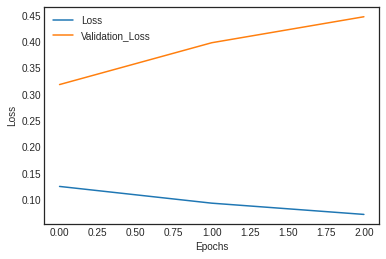

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], "")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Loss', 'Validation_Loss'])
plt.show()

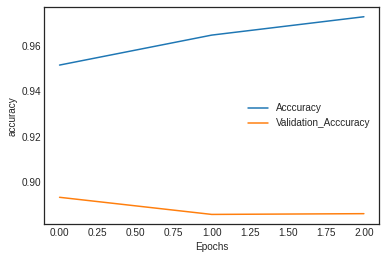

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], "")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(['Acccuracy', 'Validation_Acccuracy'])
plt.show()

## 모델 평가

In [52]:
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document', 'label']].values:
  test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([test_tokenized_text],
                          SENT_MAX_LEN,
                          value = vocab[vocab.padding_token],
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]

  test_data_sents.append(tokens)
  test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [53]:
cls_model.load_weights(checkpoint_path)
cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)

49/49 [==============================] - 69s 1s/step - loss: 0.4551 - accuracy: 0.8854


[0.4550566077232361, 0.8853731155395508]